# TelCo Churn Classification Project

###### Chad Allen
###### 01 June 2021

## Project Planning

- create a README file with project and business goals, a data dictionary, ideas and hypotheses, and how to recreate the project
- acquire the data, create a function(s) to automate the process, create acquire.py file containing the function(s), import and utilize the automated processes in the final notebook
- clean and prepare the data, create a function(s) to automate the process, create a prepare.py file containing the function(s), import and utilize the automated processes in the final notebook
- create visuals of variable distributions, create hypotheses, run statistical tests, reject or fail to reject null hypotheses, and document findings and takeaways
- establish baseline predictions, create, fit and evaluate models on the train and validate datasets, document findings and takeaways
- choose the best model to and evaluate on the test dataset, document conclusions, takeaways, and recommendations
- create a predictions.csv with customer_id, probability of churn, and predictions

## Executive Summary - Conclusions and Next Steps

- using the combination of the top 6 variables by correlation created well-fit models
- logistic regression was the best fit model with 79.18% accuracy on the test dataset
- best model was able outperform the baseline by almost 6%
- with more time, exploring additional features and adjustments to hyperparameters could improve results even further

In [15]:
import pandas as pd
import numpy as np
from scipy import stats
import os

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

from acquire import get_telco_data
from prepare import telco_prep, telco_split
from explore import explore_bivariate

import warnings
warnings.filterwarnings("ignore")

## Acquire the TelCo data

#### Bring in the data from a SQL database, put it into a DataFame, and then get to know the data

In [2]:
# use imported function to acquire the data, then take a quick look at columns and values
telcodf = get_telco_data()
telcodf.head().T

,0,1,2,3,4
payment_type_id,2,4,3,4,3
internet_service_type_id,1,1,1,1,1
contract_type_id,3,3,3,3,3
customer_id,0016-QLJIS,0017-DINOC,0019-GFNTW,0056-EPFBG,0078-XZMHT
gender,Female,Male,Female,Male,Male
senior_citizen,0,0,0,0,0
partner,Yes,No,No,Yes,Yes
dependents,Yes,No,No,Yes,No
tenure,65,54,56,20,72
phone_service,Yes,No,No,No,Yes


In [3]:
# how many rows and columns
telcodf.shape

(7043, 24)

In [4]:
# stats of numeric columns
telcodf.describe().T

,count,mean,std,min,25%,50%,75%,max
payment_type_id,7043.0,2.315633,1.148907,1.00,1.0,2.00,3.00,4.00
internet_service_type_id,7043.0,1.872923,0.737796,1.00,1.0,2.00,2.00,3.00
contract_type_id,7043.0,1.690473,0.833755,1.00,1.0,1.00,2.00,3.00
senior_citizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
monthly_charges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


In [5]:
# look at column value types
telcodf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

#### Acquire Takeaways

- wrote a SQL query to join tables to acquire all the data from the CodeUp database
- create and store a csv file to make it quicker for future use
- lots of object columns that will need to be encoded
- several columns appear to have similiar information and could be combined

## Prepare the TelCo data

#### Goal:
- reduce the number of columns to make comparing them more efficient

#### Steps taken during data prep include:
- drop any duplicates - no change in counts
- set index to customer_id - no statisical value to customer_id column
- replace spaces, investigate NaN's
-- found 11 NaN's in total charges - all occurances were customers with no tenure and did not churn
-- 11 out of 7043 observations = ~0.16%, decided to drop them because they would have no effect on calculations
- convert total_charges from 'object' to 'float64'
- tenure renamed to 'tenure_months' and created 'tenure_years' column
- encode columns with 'Yes' and 'No' values
- feature engineering - combine columns that contain related information and encode their values
-- partner and dependents -> family
-- phone_service and multiple_lines -> phone_service
-- online_security and online_backup -> online_services
-- streaming_tv and streaming_movies -> streaming_services
-- payment_type and payment_type_id -> auto_pay
-- contract_type and contract_type_id -> contract_type
-- internet_service_type and internet_service_type_id -> internet_service_type

In [6]:
# use imported function to prepare the data, then look at a sample
telcodf = telco_prep(telcodf)
telcodf.head().T

customer_id,0016-QLJIS,0017-DINOC,0019-GFNTW,0056-EPFBG,0078-XZMHT
auto_pay,0.000000,1.00,1.000000,1.000000,1.00
senior_citizen,0.000000,0.00,0.000000,0.000000,0.00
tenure_months,65.000000,54.00,56.000000,20.000000,72.00
phone_service,2.000000,0.00,0.000000,0.000000,2.00
paperless_billing,1.000000,0.00,0.000000,1.000000,1.00
monthly_charges,90.450000,45.20,45.050000,39.400000,85.15
total_charges,5957.900000,2460.55,2560.100000,825.400000,6316.20
churn,0.000000,0.00,0.000000,0.000000,0.00
contract_type,2.000000,2.00,2.000000,2.000000,2.00
internet_service_type,1.000000,1.00,1.000000,1.000000,1.00


In [7]:
# rows and columns of prepped data
telcodf.shape

(7032, 16)

In [8]:
# stats review of prepped data
telcodf.describe().T

,count,mean,std,min,25%,50%,75%,max
auto_pay,7032.0,0.435580,0.495868,0.000000,0.0000,0.000000,1.000000,1.00
senior_citizen,7032.0,0.162400,0.368844,0.000000,0.0000,0.000000,0.000000,1.00
tenure_months,7032.0,32.421786,24.545260,1.000000,9.0000,29.000000,55.000000,72.00
phone_service,7032.0,1.325228,0.642585,0.000000,1.0000,1.000000,2.000000,2.00
paperless_billing,7032.0,0.592719,0.491363,0.000000,0.0000,1.000000,1.000000,1.00
monthly_charges,7032.0,64.798208,30.085974,18.250000,35.5875,70.350000,89.862500,118.75
total_charges,7032.0,2283.300441,2266.771362,18.800000,401.4500,1397.475000,3794.737500,8684.80
churn,7032.0,0.265785,0.441782,0.000000,0.0000,0.000000,1.000000,1.00
contract_type,7032.0,0.688567,0.832934,0.000000,0.0000,0.000000,1.000000,2.00
internet_service_type,7032.0,1.224118,0.778643,0.000000,1.0000,1.000000,2.000000,2.00


In [9]:
# last check on columns and data types
telcodf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0016-QLJIS to 9986-BONCE
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   auto_pay               7032 non-null   int64  
 1   senior_citizen         7032 non-null   int64  
 2   tenure_months          7032 non-null   int64  
 3   phone_service          7032 non-null   int64  
 4   paperless_billing      7032 non-null   int64  
 5   monthly_charges        7032 non-null   float64
 6   total_charges          7032 non-null   float64
 7   churn                  7032 non-null   int64  
 8   contract_type          7032 non-null   int64  
 9   internet_service_type  7032 non-null   int64  
 10  tenure_years           7032 non-null   float64
 11  Male                   7032 non-null   uint8  
 12  family                 7032 non-null   int64  
 13  online_services        7032 non-null   int64  
 14  support_services       7032 non-null   int64  

In [10]:
# use imported function to split the data, check rows and columns of each subset
train, validate, test = telco_split(telcodf)
train.shape, validate.shape, test.shape

((3937, 16), (1688, 16), (1407, 16))

#### Prepare Takeaways

- all columns encoded to numeric values
- reduced columns down to 16
-- continuous variables = 4
-- categorical variables = 12
- split data (random_state=1234, stratify = 'churn')
-- train(56%), validate(24%) and test(20%) of original dataset

## Exploration of the TelCo data

#### Goals:

- create visualization of overall churn rate
- create visualizations of variable distributions
- create and test hypotheses

### Visualizations

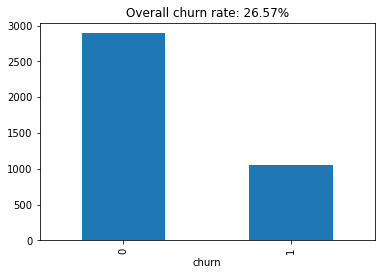

In [57]:
# overall churn rate
train.churn.value_counts().sort_index().plot.bar()
churn_rate = train.churn.mean()
plt.title(f'Overall churn rate: {churn_rate:.2%}')
plt.xlabel('churn')
plt.show()

In [13]:
# create variable groups and assign the target variable
# use top 4 variables that were identified to have 20% or greater correlation 
quant_vars = ['tenure_months']
cat_vars = ['contract_type', 'internet_service_type', 'auto_pay']
target = 'churn'

contract_type 
_____________________

         chi2        p-value  degrees of freedom
0  672.988803  7.283469e-147                   2

observed:
 churn             0     1   All
contract_type                  
0              1231   926  2157
1               737    96   833
2               923    24   947
All            2891  1046  3937

expected:
              0           1
0  1583.918466  573.081534
1   611.684785  221.315215
2   695.396749  251.603251


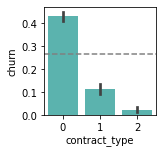


_____________________

internet_service_type 
_____________________

         chi2       p-value  degrees of freedom
0  411.000269  5.654909e-90                   2

observed:
 churn                     0     1   All
internet_service_type                  
0                       768    68   836
1                      1095   237  1332
2                      1028   741  1769
All                    2891  1046  3937

expected:
              0           1
0   613.887732  222.112268
1   978.108204  353.891796
2  1299.004064  469.995936


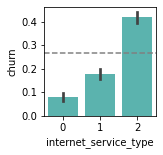


_____________________

auto_pay 
_____________________

         chi2       p-value  degrees of freedom
0  193.869652  4.546875e-44                   1

observed:
 churn        0     1   All
auto_pay                  
0         1460   789  2249
1         1431   257  1688
All       2891  1046  3937

expected:
              0           1
0  1651.475489  597.524511
1  1239.524511  448.475489


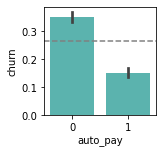


_____________________

tenure_months 
____________________



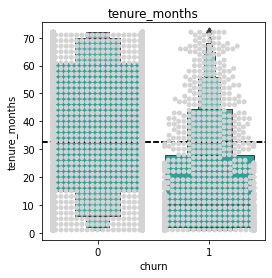

        count       mean        std  min   25%   50%   75%   max
churn                                                           
0      2891.0  38.018333  24.250795  1.0  15.0  39.0  61.0  72.0
1      1046.0  17.637667  19.100432  1.0   2.0  10.0  28.0  72.0 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=2260899.0, pvalue=4.772345740237127e-125)

____________________



In [16]:
# use imported function to create bivariate visualizations
explore_bivariate(train, target, cat_vars, quant_vars)

#### Visualizations Takeaways

- contract_type (values: 0 = 'Month-to-month', 1 = 'One year', 2 = 'Two year')
-- low p-score = 7.283469e-147
-- Month-to-month has the highest rate of churn
- internet_service type (values: 0 = 'None', 1 = 'DSL', 2 = 'Fiber optic')
-- low p-value = 5.654909e-90
-- Fiber optic has the highest rate of churn
- auto_pay (values: 0 = manual_pay, 1 = auto_pay)
-- low p-value = 4.546875e-44
-- manual_pay has the highest rate of churn
- tenure_months
-- low p-value = 4.772345740237127e-125
-- majority of churn occurs with tenure less than 30 months

### Hypothesis Testing

#### Internet Service Type

- Does the type of internet service affect churn?
- The heatmap shows this category has the highest positive correlation.

Form hypothesis #1:

- $H_0$: The type of internet service has no affect on churn.
- $H_a$: The type of internet service does have an affect on churn.

Will use chi^2 test to compare 2 categorical variables - internet_service_type and churn

In [46]:
# examine the 3 types of internet service and the relation to churn
# make a crosstab
observed1 = pd.crosstab(train.internet_service_type, train.churn)

# run the chi^2 test
chi2, p, degf, expected = stats.chi2_contingency(observed1)

# set alpha
alpha = 0.05

# compare p-value and alpha
print(f'p-value: {p}, alpha: {alpha}')

null_hypothesis = "the type of internet service has no affect on churn."

if p < alpha:
    print(f'\nWe can reject the null hypothesis that', null_hypothesis)
else:
    print(f'\nWe fail to reject the null hypothesis.')

p-value: 5.654909106259869e-90, alpha: 0.05

We can reject the null hypothesis that the type of internet service has no affect on churn.


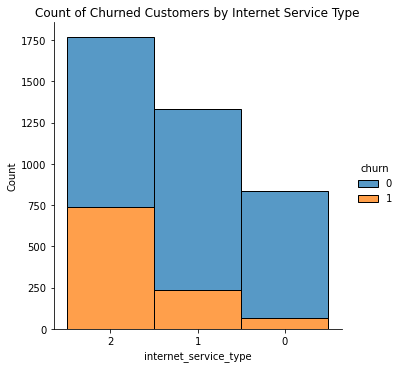

In [40]:
# visual of internet service type customers that have and have not churned
# internet_service_types values = (0 = 'None', 1 = 'DSL', 2 = 'Fiber optic')
# churn values = (0 = have not churned, 1 = have churned)
sns.displot(data=train, x=train.internet_service_type.astype(str), hue='churn', multiple='stack')
plt.title('Count of Churned Customers by Internet Service Type')
plt.show()

#### Takeaways

- there is evidence to support the idea that internet service type has an affect on churn
- churn rate for internet service types:
-- no internet service = 68 / (68 + 768) = 0.0813
-- DSL = 237 / (237 + 1095) = 0.1779
-- Fiber optic = 741 / (741 + 1028) = 0.4189
- Fiber optic service has the highest rate of churn within the internet service type category
- Fiber optic churn rate is higher than the overall churn rate

#### Automatic Payment

- Does having a form of auto-pay affect churn?
- The heatmap shows this category has the third highest negative correlation.

Form hypothesis #2:

- $H_0$: Having a form of auto-pay has no affect on churn.
- $H_a$: Having a form of auto-pay does have an affect on churn.

Will use chi^2 test to compare 2 categorical variables - auto_pay and churn

In [47]:
# examine auto-pay and the relation to churn
# make a crosstab
observed2 = pd.crosstab(train.auto_pay, train.churn)

# run the chi^2 test
chi2, p, degf, expected = stats.chi2_contingency(observed2)

# set alpha
alpha = 0.05

# compare p-value and alpha
print(f'p-value: {p}, alpha: {alpha}')

null_hypothesis = "having a form of auto-pay has no affect on churn."

if p < alpha:
    print(f'\nWe can reject the null hypothesis that', null_hypothesis)
else:
    print(f'\nWe fail to reject the null hypothesis.')

p-value: 4.546875469756717e-44, alpha: 0.05

We can reject the null hypothesis that having a form of auto-pay has no affect on churn.


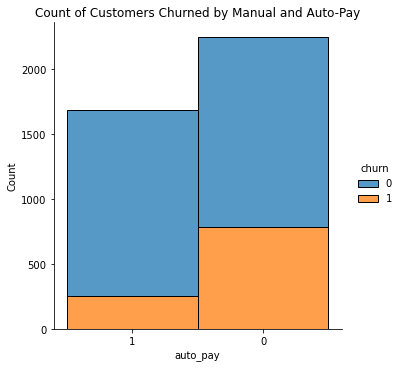

In [41]:
# visual of manual and auto-pay customers that have and have not churned
# auto_pay values = (0 = manual_pay, 1 = auto_pay)
# churn values = (0 = have not churned, 1 = have churned)
sns.displot(data=train, x=train.auto_pay.astype(str), hue='churn', multiple='stack')
plt.title('Count of Customers Churned by Manual and Auto-Pay')
plt.show()

#### Takeaways

- there is evidence to support the idea that auto-payment has an affect on churn
- churn rates for manual or auto-pay:
-- manual = 789 / (789 + 1460) = 0.3508
-- auto-pay = 257 / (257 + 1431) = 0.1523
- Manual pay has the highest rate of churn within the auto-pay category
- Manual pay churn rate is higher than the overall churn rate

## Modeling the Telco data

#### Goals:
- baseline prediction
- create 3 unique classification models
-- using all of the variables would cause overfitting
-- will use top 6 variables with correlation over 20%
--- contract_type, tenure_months, internet_service_type, auto_pay, paperless_billing, family

#### Baseline Prediction

In [24]:
# split train, validate and test into X(variables) and y(target)
X_train, y_train = train.drop(columns='churn'), train.churn
X_validate, y_validate = validate.drop(columns='churn'), validate.churn
X_test, y_test = test.drop(columns='churn'), test.churn

# check values counts to establish baseline
train.churn.value_counts(), train.churn.value_counts(normalize=True)

(0    2891
 1    1046
 Name: churn, dtype: int64,
 0    0.734315
 1    0.265685
 Name: churn, dtype: float64)

In [59]:
# baseline prediction = 0 (not churned)

# create the baseline with constant equal to highest value
baseline = DummyClassifier(strategy='constant', constant=0)
# fit the baseline to the train subset
baseline.fit(X_train, y_train)
# accuracy of the baseline on the train subset
print(f'Baseline accuracy on the train subset: {baseline.score(X_train, y_train):.4}')

Baseline accuracy on the train subset: 0.7343


#### Create features list

In [28]:
# features having more than 20% correlation
features = ['auto_pay', 'tenure_months', 'paperless_billing', 'contract_type', 'internet_service_type', 'family']

#### Model 1 - Logistic Regression

In [58]:
# create the model
logit = LogisticRegression(random_state=1234)

# fit the model
logit.fit(X_train[features], y_train)

# use the model to make predictions
y_pred_logit = logit.predict(X_train[features])

# use the model to predict probabilities
y_pred_proba_logit = logit.predict_proba(X_train[features])

# classification report
print('Classification report:\n',classification_report(y_train, y_pred_logit))

# accuracy of the baseline on the train subset
print(f'Baseline accuracy on the train subset: {baseline.score(X_train, y_train):.4}')

# accuracy of the model
print(f'\nModel score for logit on train subset is: {logit.score(X_train[features], y_train):.4}')
print(f'Model score for logit on validate subset is: {logit.score(X_validate[features], y_validate):.4}')

Classification report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      2891
           1       0.66      0.54      0.59      1046

    accuracy                           0.80      3937
   macro avg       0.75      0.72      0.73      3937
weighted avg       0.79      0.80      0.80      3937

Baseline accuracy on the train subset: 0.7343

Model score for logit on train subset is: 0.8031
Model score for logit on validate subset is: 0.7986


#### Takeaways

- logistic regression - using top 6 features 
-- accuracy on train and validate subsets beat the baseline accuracy
-- hyperparameters - random_state

#### Model 2 - Decision Tree

In [60]:
# create the model
tree = DecisionTreeClassifier(max_depth=3, random_state=1234)

# fit the object
tree.fit(X_train[features], y_train)

# use the model to make predictions
y_pred_tree = tree.predict(X_train[features])

# use the model to predict probabilities
y_pred_proba_tree = tree.predict_proba(X_train[features])

# classification report
print('Classification report:\n',classification_report(y_train, y_pred_tree))

# accuracy of the baseline on the train subset
print(f'Baseline accuracy on the train subset: {baseline.score(X_train, y_train):.4}')

# accuracy of the model
print(f'\nModel score for tree on train subset is: {tree.score(X_train[features], y_train):.4}')
print(f'Model score for tree on validate subset is: {tree.score(X_validate[features], y_validate):.4}')

Classification report:
               precision    recall  f1-score   support

           0       0.81      0.94      0.87      2891
           1       0.69      0.39      0.50      1046

    accuracy                           0.79      3937
   macro avg       0.75      0.66      0.68      3937
weighted avg       0.78      0.79      0.77      3937

Baseline accuracy on the train subset: 0.7343

Model score for tree on train subset is: 0.7907
Model score for tree on validate subset is: 0.7891


#### Takeaways

- decision tree - using top 6 features
- accuracy on train and validate subsets beat the baseline accuracy
-- hyperparameters - max_depth, random_state

#### Model 3 - Random Forest

In [61]:
# create the model
rf = RandomForestClassifier(max_depth=5, min_samples_leaf=1, random_state=1234)

# fit the object
rf.fit(X_train[features], y_train)

# use the model to make predictions
y_pred_rf = rf.predict(X_train[features])

# use the model to predict probabilities
y_pred_proba_rf = rf.predict_proba(X_train[features])

# classification report
print('Classification report:\n',classification_report(y_train, y_pred_rf))

# accuracy of the baseline on the train subset
print(f'Baseline accuracy on the train subset: {baseline.score(X_train, y_train):.4}')

# accuracy of the model
print(f'\nModel score for rf on train subset is: {rf.score(X_train[features], y_train):.4}')
print(f'Model score for rf on validate subset is: {rf.score(X_validate[features], y_validate):.4}')

Classification report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87      2891
           1       0.68      0.50      0.58      1046

    accuracy                           0.81      3937
   macro avg       0.76      0.71      0.73      3937
weighted avg       0.79      0.81      0.79      3937

Baseline accuracy on the train subset: 0.7343

Model score for rf on train subset is: 0.8052
Model score for rf on validate subset is: 0.7867


#### Takeaways

- random forest - using 6 features
- accuracy on train and validate subsets beat the baseline accuracy
-- hyperparameters - max_depth, min_samples_leaf, random_state

## Evaluate the Models for Best Fit

- compare accuracy scores
- select best fit model
- evaluate on test data

In [63]:
# accuracy of the baseline on the train subset
print(f'Baseline accuracy on the train subset: {baseline.score(X_train, y_train):.4}')

# accuracy of the logistic regression model
print(f'\nModel score for logistic regression on train subset is: {logit.score(X_train[features], y_train):.4}')
print(f'Model score for logistic regression on validate subset is: {logit.score(X_validate[features], y_validate):.4}')

# accuracy of the decision tree model
print(f'\nModel score for decision tree on train subset is: {tree.score(X_train[features], y_train):.4}')
print(f'Model score for decision tree on validate subset is: {tree.score(X_validate[features], y_validate):.4}')

# accuracy of the random forest model
print(f'\nModel score for random forest on train subset is: {rf.score(X_train[features], y_train):.4}')
print(f'Model score for random forest on validate subset is: {rf.score(X_validate[features], y_validate):.4}')

Baseline accuracy on the train subset: 0.7343

Model score for logistic regression on train subset is: 0.8031
Model score for logistic regression on validate subset is: 0.7986

Model score for decision tree on train subset is: 0.7907
Model score for decision tree on validate subset is: 0.7891

Model score for random forest on train subset is: 0.8052
Model score for random forest on validate subset is: 0.7867


#### Takeaways

- will move forward with logistic regression model
-- accuracy beat baseline
-- least drop-off between train and validate (best fit)
- will use top 6 variables with correlation over 20%
- hyperparameters - random_state
-- adding and/or adjusting hyperparameters could improve results

### Evaluate on Test Dataset

In [65]:
# accuracy of the baseline on the train subset
print(f'Baseline accuracy on the train subset: {baseline.score(X_train, y_train):.4}')

# accuracy of the logistic regression model on train and validate
print(f'\nModel score for logistic regression on train subset is: {logit.score(X_train[features], y_train):.4}')
print(f'Model score for logistic regression on validate subset is: {logit.score(X_validate[features], y_validate):.4}')

# accuracy of the logistic regression model on test data
print(f'\nModel score for logistic regression on test subset is: {logit.score(X_test[features], y_test):.4}')

Baseline accuracy on the train subset: 0.7343

Model score for logistic regression on train subset is: 0.8031
Model score for logistic regression on validate subset is: 0.7986

Model score for logistic regression on test subset is: 0.7918


#### Takeaways

- accuracy on test was only slightly lower than train and validate
- indicates a fairly well fit model
- beat the baseline accuracy by almost 6%

## Conclusions

- overall churn rate of 26.57%
- contract type - Month-to-month has the highest rate of churn (42.93%)
- internet service type - Fiber optic has the highest rate of churn (41.89%)
- auto pay - manual_pay has the highest rate of churn (15.23%)
- tenure - majority of churn occurs with tenure less than 30 months

## Key Takeaways

- using the combination of the top 6 variables by correlation created a well-fit models
-- focus on these areas has the largest potential to impact churn
- best fit model(LogisticRegression) was able to predict churn at a higher rate than the baseline

## Recommendations

- offer incentives to get more customers to convert to either a contract and/or use auto-pay
- investigate cause of churn for fiber optic service customers
-- is it quality of service(stability, speed, etc), cost(overall, value), customer support(tech, device)?
-- is there a relation to support, online and/or streaming services related to fiber optic service?
- investigate further into churn of fiber optic customers and at what point they churn